## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., ist ein Agent, der Einen Browser per Maus und Keyboard steuern kann.

Die grundlegende Architektur ist ReAct.

Mit etwas Javascript werden deterministisch in jedem Schritt die relevanten Felder (Buttons, Texteingabe etc.) annotiert, dann wird ein Screenshot gemacht und an ein multimodales Modell geschickt. Dieses kann dann entscheiden, wie es vorgehen möchte.

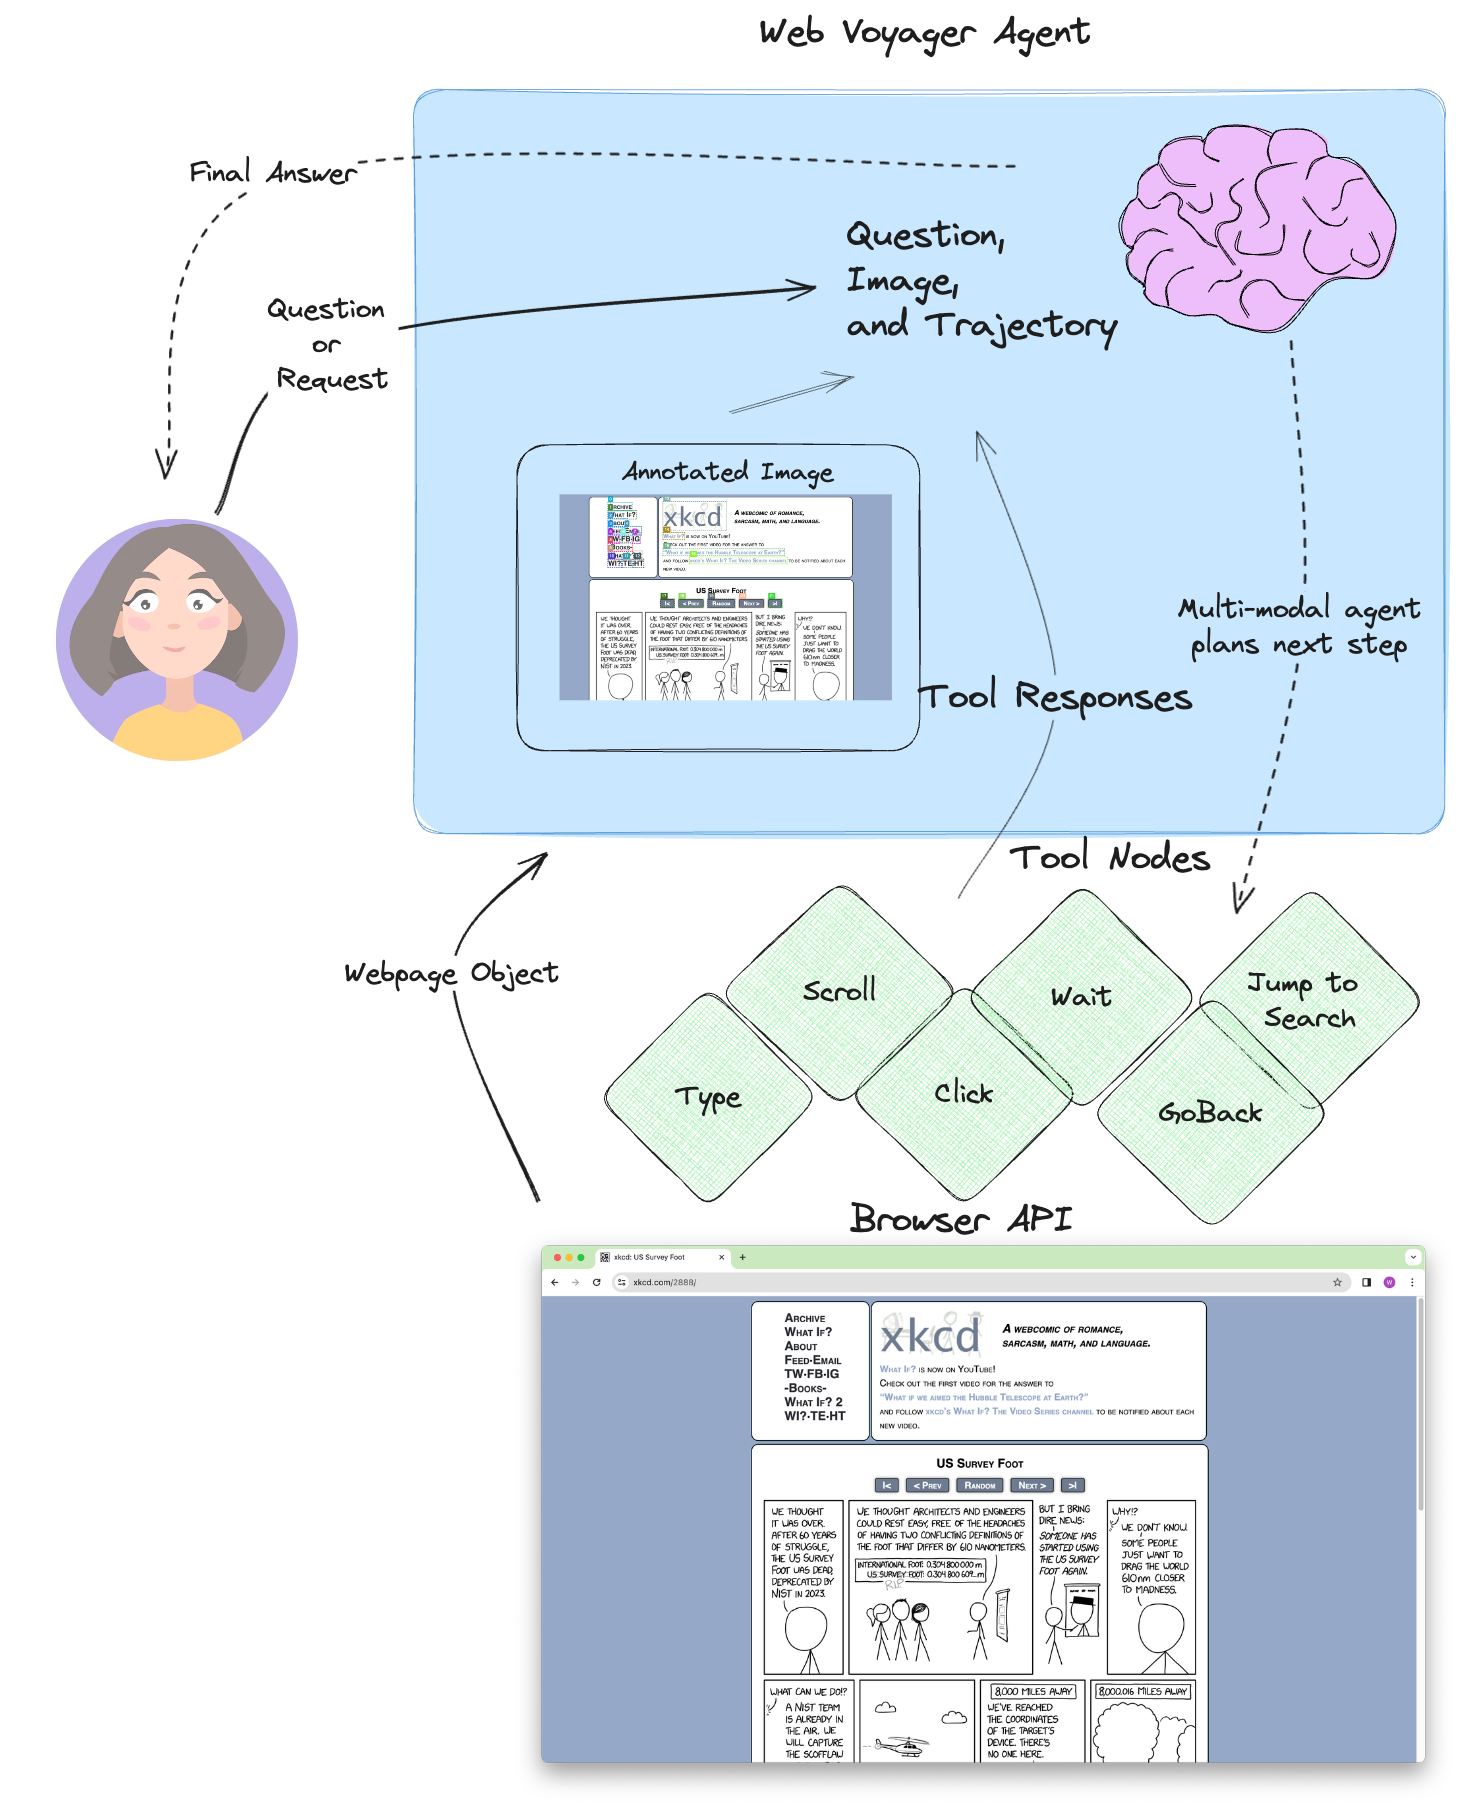


In [ ]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Der State

The state provides the inputs to each node in the graph.

Der State beinhaltet

- Die ursprüngliche Nutzeranfrage
- Die Webseite im Browser
- Den aktuell Screenshot
- Die Liste von relevanten HTML-Elementen (Buttons, Eingabefelder etc.) vom Javascript
- Das Scratchpad und weitere Informationen


In [ ]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool

## Tools

Der Agent hat 6 einfach Tools

- Klicken
- Text in Eingabefeld schreiben
- Scrollen
- Warten (Falls noch etwas lädt)
- Zurück navigieren
- Zur Suchmaschine navigieren (Google)


In [ ]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except:  # noqa: E722
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

## Der Agent

Der Agent benützt ein multimodales Modell. Die einzelnen Schritte im Agenten sind wie folgt:

- Javascript markiert alle relevanten HTML-Elemente mit einer Box und einer Zahl. Das LLM kann dann diese Boxen referenzieren, wenn es eine Aktion durchführen will (Klick Kästchen 4).
- Das annotierte Bild, Scratchpad und die Nutzeranfrage werden an das LLM geschickt.
- Der Output muss entsprechen geparsed werden, damit das Tool das richtige tut.

#### Zuerst unsere Markierungsfunktion


In [ ]:
import base64

from langchain_core.runnables import chain as chain_decorator

with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except _:
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Jetzt setzen wir alles in einer Chain zusammen


In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}

In [ ]:
from helpers import llm

model = llm(temperature=0, model="gpt-4-vision-preview", max_tokens=4096)
prompt = hub.pull("wfh/web-voyager")
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | model | StrOutputParser() | parse
)

#### Das Scratchpad

Das Scratchpad wird hier aus Systemnachrichten aufgebaut, die wir selbst in einem hübschen Format erzeugen.


In [ ]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

## Der Graph


In [ ]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [ ]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

#### Eine Funktion zur Ausgabe der Zwischenschritte


In [ ]:
from playwright.async_api import async_playwright
from PIL import Image as PILImage
import io
import base64

browser = await async_playwright().start()

browser = await browser.chromium.launch(headless=True, args=None)
page = await browser.new_page()
await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")

        screenshot_image = PILImage.open(io.BytesIO(base64.b64decode(event["agent"]["img"])))
        display(screenshot_image)
        print(action, action_input)

        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

## Los gehts


In [ ]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to Wuerzburg by 9 o'clock by car? starting from Munich main station.",
    page,
)
print(f"Final response: {res}")